Notes: I want to build a model using both the randomized regions. How to do it? Should I add randomized region 2 to the training data as separate points, so that the model learns one that fits both? Or should I have separate parameters for the two regions and then merge them?

Also, I want to learn a model of the splice donor/acceptor. How could I do that? I could take all data, select splice sites that occur within randomimzed regions, and train a model on the sequence within a certain fixed window of that splice site.

Or, for each splice site, I could take the exonic sequences from 0 to that splice site and train the model on those. This gets rid of the need to have a specific splice site score, but I still feel sort of odd doing it.

In [35]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, Merge, Reshape
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

In [91]:
num_filters = [100,64,32]
filter_length = [6,6,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(keras_pooling.SumLayer())
model1.add(Reshape((num_filters[1],)))
#model1.add(Flatten())
#model1.add(Dense(output_dim=1, activation='linear'))
#model1.add(Activation('sigmoid'))

model2 = Sequential()
model2.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model2.add(Dropout(0.25))
model2.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model2.add(keras_pooling.SumLayer())
model2.add(Reshape((num_filters[1],)))

#model2.add(Flatten())

model3 = Sequential()
model3.add(Merge([model1, model2], mode='concat', concat_axis=1))
model3.add(Dense(output_dim=4, activation='linear'))
model3.add(Activation('sigmoid'))

In [92]:
model1.layers[-1].output_shape

(None, 64)

In [88]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
X1_train = X_train.map(lambda x: x[0:25])
X2_train = X_train.map(lambda x: x[25:])
X1_test = X_test.map(lambda x: x[0:25])
X2_test = X_test.map(lambda x: x[25:])

#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

X2_train = np.dstack(X2_train)
X2_train = np.rollaxis(X2_train, 2)
X2_test = np.dstack(X2_test)
X2_test = np.rollaxis(X2_test, 2)

Y1_test = Y_test[:,0]
Y1_train = Y_train[:,0]
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
Y3_test = Y_test[:,79]
Y3_train = Y_train[:,79]
Yn_test = 1 - Y1_test - Y2_test - Y3_test #Y_test[:,303]
Yn_train = 1 - Y1_train - Y2_train - Y3_train #Y_train[:,303]
Y_test_small = np.dstack([Y1_test, Y2_test, Y3_test, Yn_test])
Y_train_small = np.dstack([Y1_train, Y2_train, Y3_train, Yn_train])
Y_test_small = Y_test_small.reshape(
    (Y_test_small.shape[1], Y_test_small.shape[2]))
Y_train_small = Y_train_small.reshape(
    (Y_train_small.shape[1], Y_train_small.shape[2]))

In [93]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [94]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model3.fit([X1_train, X2_train], Y_train_small,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=([X1_test, X2_test], Y_test_small),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 427s - loss: 1.0529 - val_loss: 0.9937
Epoch 2/50
212035/212035 [==============================] - 435s - loss: 0.9268 - val_loss: 0.8886
Epoch 3/50
212035/212035 [==============================] - 430s - loss: 0.8951 - val_loss: 0.8745
Epoch 4/50
212035/212035 [==============================] - 426s - loss: 0.8822 - val_loss: 0.8795
Epoch 5/50
212035/212035 [==============================] - 431s - loss: 0.8757 - val_loss: 0.8635
Epoch 6/50
212035/212035 [==============================] - 4476s - loss: 0.8705 - val_loss: 0.8572
Epoch 7/50
212035/212035 [==============================] - 482s - loss: 0.8669 - val_loss: 0.8580
Epoch 8/50
212035/212035 [==============================] - 471s - loss: 0.8639 - val_loss: 0.8527
Epoch 9/50
212035/212035 [==============================] - 478s - loss: 0.8609 - val_loss: 0.8479
Epoch 10/50
212035/212035 [==============================

In [ ]:
pred = model3.predict()

In [45]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

In [95]:
predictions = model3.predict([X1_test, X2_test])

In [96]:
r2_score(Y_test_small, predictions)

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/regression.py:471: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)


-0.094270852620283285

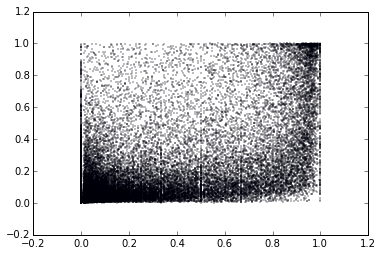

In [102]:
plt.scatter(Y_test_small[:,0], predictions[:,0], s=0.1)
plt.show()

In [77]:
from keras import backend as K

expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

# new in keras 1.0: need a learning phase argument
get_3rd_layer_output_1 = K.function([model1.layers[0].input, model2.layers[0].input, K.learning_phase()],
                                  [model3.layers[-1].output])
def get_score(input_data):
    return get_3rd_layer_output_1([np.zeros(input_data.shape), input_data, 1])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [78]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [79]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]

In [80]:
hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

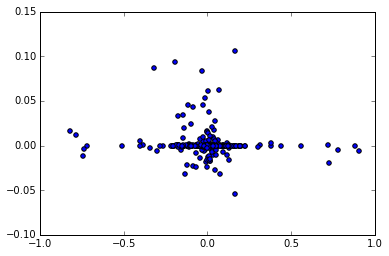

In [81]:
plt.scatter(actual, model_pred_2)